# Reconstructing an *off-axis* hologram by Convolution approach

Reference: Digital holography and wavefront sensing by Ulf Schnars, Claas Falldorf, John Watson, and Werner Jüptner, Springer-verlag Berlin an, 2016. (Section 3.2)

## Info about the digital hologram:
'ulf7.BMP' is a digital hologram created by recording an object at about 1 meter distance with HeNe laser (632.8 nm) and an image sensor with 6.8 µm pixel size. 

In [1]:
#Import libraries realted to matplotlib and mathematical operations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [3]:
!pip install pillow watermark

     |████████████████████████████████| 2.0MB 3.3MB/s eta 0:00:01


In [11]:
%load_ext watermark

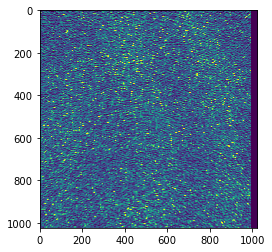

In [4]:
# Read the hologram image file
hologram = mpimg.imread('ulf7.BMP')
hologram = hologram.astype(float) #Convert into float type. Crucial for non integer based mathematical operations
# plot/view the hologram
imgplot = plt.imshow(hologram, cmap="viridis")

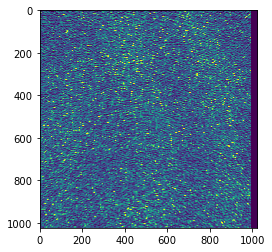

In [5]:
# DC term suppression. It involves subtraction of the mean value of hologram from itself
hologram2 = hologram - np.mean(hologram)
# plot/view the hologram
imgplot = plt.imshow(hologram2, cmap="viridis")

## Some equations from the book!
The *Fresnel-Kirchhoff* integral describing diffraction field beyond an aperture is given by the coherent superposition of the secondary waves (section 2.4)
\begin{equation}
\Gamma\left(\xi^{\prime}, \eta^{\prime}\right)=\frac{i}{\lambda} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} A(x, y) \frac{\exp \left(-i \frac{2 \pi}{\lambda} \rho^{\prime}\right)}{\rho^{\prime}} Q d x d y
\end{equation}
where, $A(x, y)$ is the complex amplitude in the plane of the diffracting aperture, $\rho^{\prime}$ is the distance between a point in the aperture plane and a point in the observation plane, and $Q$ is the inclination factor defined to take care of no backward propagation of the diffracted optical field. For holograms, $Q$ is approximately equal to 1.

A hologram $h(x,y)$ recorded by a reference light wave $E_{R}(x, y)$ can be reconstructed by a conjugate reference wave $E_{R}^{*}(x, y)$ as described by the following *Fresnel-Kirchhoff* integral
\begin{equation}
\Gamma(\xi, \eta)=\frac{i}{\lambda} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} h(x, y) E_{R}^{*}(x, y) \frac{\exp \left(-i \frac{2 \pi}{\lambda} \rho\right)}{\rho} d x d y
\end{equation}

The above equation can be interpreted as a superposition integral 
\begin{equation}
\Gamma(\xi, \eta)= \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} h(x, y) E_{R}^{*}(x, y) g(\xi, \eta, x, y) d x d y
\end{equation}
where $g(\xi, \eta, x, y)$ is the impulse response function given by
\begin{equation}
g(\xi, \eta, x, y)=\frac{i}{\lambda} \frac{\exp \left[-i \frac{2 \pi}{\lambda} \sqrt{d^{2}+(x-\xi)^{2}+(y-\eta)^{2}}\right]}{\sqrt{d^{2}+(x-\xi)^{2}+(y-\eta)^{2}}}.
\end{equation}
These equations ensure that $\Gamma$ is a convolution of $h E_{R}^{*}$ and $g$. Hence, 
\begin{equation}
\Gamma(\xi, \eta)=\Im^{-1}\left\{\Im\left(h \cdot E_{R}^{*}\right) \cdot \Im(g)\right\}
\end{equation}
where for the digital case impulse response function is given by
\begin{equation}
g(k, l)=\frac{i}{\lambda} \frac{\exp \left[-i \frac{2 \pi}{\lambda} \sqrt{d^{2}+k^{2} \Delta x^{2}+l^{2} \Delta y^{2}}\right]}{\sqrt{d^{2}+k^{2} \Delta x^{2}+l^{2} \Delta y^{2}}}
\end{equation}
and $E_{R}^{*}$ includes the field response due to the numerical reconstruction lens whose focal length depends on the object distance $d$ and magnification factor in reconstruction $m$.
\begin{equation}
E_{R}^{*} = L(k,l) = \exp \left[i \frac{\pi}{\lambda f}\left(k^{2} \Delta x^{2} + l^{2} \Delta y^{2} \right)\right] =\exp \left[i \frac{\pi}{\lambda}\left(\frac{1}{d}+\frac{1}{md}\right)\left(k^{2} \Delta x^{2} + l^{2} \Delta y^{2} \right)\right]
\end{equation}

In [6]:
# prepare the Convolution operand for the hologram
Nr,Nc = np.shape(hologram) #number of rows and columns in the hologram
wavelength = 632.8e-9 #HeNe laser wavelength in SI units i.e. meters
dx = 6.8e-6 #sensor pixel size in meters
d = 1.054 #object distance in meters
m = 1/14 #magnification factor
d2 = d*m #reconstruction distance in meters
f = 1/(1/d+1/d2) #lens responsible for imaging an object kept at d distance to an image at d2 distance 
Nr = np.linspace(0, Nr-1, Nr)-Nr/2
Nc = np.linspace(0, Nc-1, Nc)-Nc/2 
k, l = np.meshgrid(Nc,Nr)

L = np.exp(1j*np.pi/(f*wavelength)*(np.multiply(k, k)*dx**2 + np.multiply(l, l)*dx**2))
rho = np.sqrt(d2**2 + np.multiply(k, k)*dx**2 + np.multiply(l, l)*dx**2)
g = 1j/wavelength*np.exp(-1j*2*np.pi/wavelength*rho)/(rho)
factor = np.multiply(hologram, L)
factor2 = np.multiply(hologram2, L) #DC term suppressed
reconstructed_field = np.fft.fftshift( np.fft.ifft2(np.multiply(np.fft.fft2(factor), np.fft.fft2(g))) ) 
reconstructed_field2 = np.fft.fftshift( np.fft.ifft2(np.multiply(np.fft.fft2(factor2), np.fft.fft2(g))) ) # DC term suppressed 

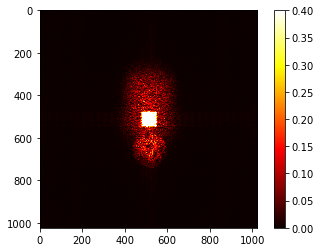

In [7]:
# save and plot 
I = np.abs(reconstructed_field)/np.max(np.abs(reconstructed_field)) #normalized intensity profile
plt.imshow(I, cmap="hot", clim=(0.0, 0.4))
plt.colorbar()
mpimg.imsave('Convolution_reconstruction.png', I, cmap="hot", vmin=0.0, vmax=0.3) #save reconstruction matrix as image

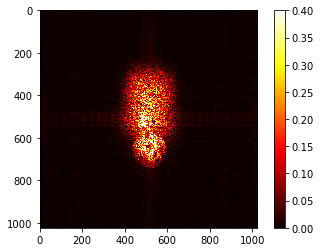

In [8]:
# save and plot DC suppressed hologram
I2 = np.abs(reconstructed_field2)/np.max(np.abs(reconstructed_field2)) #normalized intensity profile
plt.imshow(I2, cmap="hot", clim=(0.0, 0.4))
plt.colorbar()
mpimg.imsave('Convolution_reconstruction_DCsuppressed.png', I2, cmap="hot", vmin=0.0, vmax=0.6) #save reconstruction matrix as image

In [12]:
%watermark

2019-05-02T06:46:54+00:00

CPython 3.7.3
IPython 7.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.14.91+
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
